In [1]:
!pip install clickhouse_connect
!pip install kaggle
!pip install plotly

In [4]:
#import os

# Imposta la variabile d'ambiente per il path corrente
#os.environ['KAGGLE_CONFIG_DIR'] = os.getcwd()

In [1]:
import clickhouse_connect
client = clickhouse_connect.get_client(host='clickhouse', port=8123)
client.command('SELECT timezone()')

'UTC'

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np
import pandas as pd

def query_to_df(query):
    """Execute a query and return the results as a DataFrame."""
    result = client.query(query)
    return pd.DataFrame(result.result_rows, 
                        columns=result.column_names)

In [6]:
query_to_df("DESCRIBE TABLE sp500_stocks")


,name,type,default_type,default_expression,comment,codec_expression,ttl_expression
0,date,Date,,,,,
1,open,Float32,,,,,
2,high,Float32,,,,,
3,low,Float32,,,,,
4,close,Float32,,,,,
5,volume,UInt64,,,,,
6,ticker,String,,,,,


In [3]:
df = pd.read_csv('./sp500_data/all_stocks_5yr.csv')


df.rename(columns={
    'Date': 'date',
    'Open': 'open',
    'High': 'high',
    'Low': 'low',
    'Close': 'close',
    'Volume': 'volume',
    'Name': 'ticker'
}, inplace=True)

# date in date.time pandas
df['date'] = pd.to_datetime(df['date']).dt.date

In [4]:
df.head()

,date,open,high,low,close,volume,ticker
0,2013-02-08,15.07,15.12,14.63,14.75,8407500,AAL
1,2013-02-11,14.89,15.01,14.26,14.46,8882000,AAL
2,2013-02-12,14.45,14.51,14.10,14.27,8126000,AAL
3,2013-02-13,14.30,14.94,14.25,14.66,10259500,AAL
4,2013-02-14,14.94,14.96,13.16,13.99,31879900,AAL


In [5]:
df.isnull().sum()
df.dropna(inplace=True)

In [6]:
query = """
SELECT
    ticker,
    COUNT(*) AS num_records
FROM sp500_stocks
GROUP BY ticker
ORDER BY num_records ASC

"""

num_records = query_to_df(query)
num_records

,ticker,num_records
0,APTV,44
1,DWDP,109
2,BHF,142
3,BHGE,152
4,DXC,215
...,...,...
500,XYL,1259
501,BIIB,1259
502,IR,1259
503,UAA,1259


In [7]:
count = num_records[num_records['num_records'] == 1259].shape[0]
print(f"Numero di record con valore 1259: {count}")


Numero di record con valore 1259: 468


In [24]:
Rendimenti = """
SELECT
    ticker,
    date,
    close,
    log_return,
    sum(log_return) OVER (
        PARTITION BY ticker
        ORDER BY date ASC
        ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW
    ) AS cumulative_log_return
FROM (
    SELECT
        ticker,
        date,
        close,
        log(close) - log(lagInFrame(close, 1, close) OVER (
            PARTITION BY ticker
            ORDER BY date ASC
            ROWS BETWEEN 1 PRECEDING AND 1 PRECEDING
        )) AS log_return
    FROM sp500_stocks
) AS t
ORDER BY ticker, date

"""

Log_Ret = query_to_df(Rendimenti)
Log_Ret

,ticker,date,close,log_return,cumulative_log_return
0,A,2013-02-08,45.080002,0.000000,0.000000
1,A,2013-02-11,44.599998,-0.010705,-0.010705
2,A,2013-02-12,44.619999,0.000448,-0.010257
3,A,2013-02-13,44.750000,0.002909,-0.007347
4,A,2013-02-14,44.580002,-0.003806,-0.011153
...,...,...,...,...,...
619024,ZTS,2018-02-01,77.820000,0.014106,0.856377
619025,ZTS,2018-02-02,76.779999,-0.013454,0.842923
619026,ZTS,2018-02-05,73.830002,-0.039179,0.803744
619027,ZTS,2018-02-06,73.269997,-0.007614,0.796130


In [25]:
Log_Ret.head(1263)

,ticker,date,close,log_return,cumulative_log_return
0,A,2013-02-08,45.080002,0.000000,0.000000
1,A,2013-02-11,44.599998,-0.010705,-0.010705
2,A,2013-02-12,44.619999,0.000448,-0.010257
3,A,2013-02-13,44.750000,0.002909,-0.007347
4,A,2013-02-14,44.580002,-0.003806,-0.011153
...,...,...,...,...,...
1258,A,2018-02-07,68.059998,-0.005713,0.411951
1259,AAL,2013-02-08,14.750000,0.000000,0.000000
1260,AAL,2013-02-11,14.460000,-0.019857,-0.019857
1261,AAL,2013-02-12,14.270000,-0.013227,-0.033084


In [26]:
Stat='''
SELECT
    ticker,
    count() AS num_days,
    round(avg(log_return) * 252, 4) AS annualized_avg_return,
    round(stddevPop(log_return) * sqrt(252), 4) AS annualized_volatility
FROM sp500_stocks_with_returns
GROUP BY ticker
ORDER BY annualized_avg_return DESC
'''

S=query_to_df(Stat)
S

,ticker,num_days,annualized_avg_return,annualized_volatility
0,NVDA,1259,0.5840,0.3452
1,NFLX,1259,0.4655,0.4278
2,DXC,215,0.4060,0.1923
3,ALGN,1259,0.3940,0.3226
4,EA,1259,0.3919,0.3124
...,...,...,...,...
500,RRC,1259,-0.3412,0.4356
501,CHK,1259,-0.3895,0.6591
502,EVHC,297,-0.5914,0.5023
503,UA,463,-0.7007,0.4700


In [33]:
S.head(11)

,ticker,num_days,annualized_avg_return,annualized_volatility
0,NVDA,1259,0.5840,0.3452
1,NFLX,1259,0.4655,0.4278
2,DXC,215,0.4060,0.1923
3,ALGN,1259,0.3940,0.3226
4,EA,1259,0.3919,0.3124
5,STZ,1259,0.3814,0.2496
6,AVGO,1259,0.3813,0.3169
7,FB,1259,0.3688,0.3106
8,MU,1259,0.3383,0.4347
9,AMZN,1259,0.3379,0.2876


In [41]:
# filtro la tabella Log_ret sulle prime 10 azioni con media annua maggiore
Hist='''
SELECT
    ticker,
    date,
    log_return,
    cumulative_log_return
FROM sp500_stocks_with_returns
WHERE ticker IN ('NVDA', 'NFLX', 'ALGN', 'EA', 'STZ', 'AVGO', 'FB', 'MU', 'AMZN','ATVI')

'''

H=query_to_df(Hist)
H

,ticker,date,log_return,cumulative_log_return
0,ALGN,2013-02-08,0.000000,0.000000
1,ALGN,2013-02-11,0.009124,0.009124
2,ALGN,2013-02-12,-0.000303,0.008821
3,ALGN,2013-02-13,-0.008210,0.000611
4,ALGN,2013-02-14,-0.005818,-0.005207
...,...,...,...,...
12585,STZ,2018-02-01,0.005543,1.935722
12586,STZ,2018-02-02,-0.021990,1.913732
12587,STZ,2018-02-05,-0.022911,1.890821
12588,STZ,2018-02-06,0.024762,1.915583


# Densità di probabilità

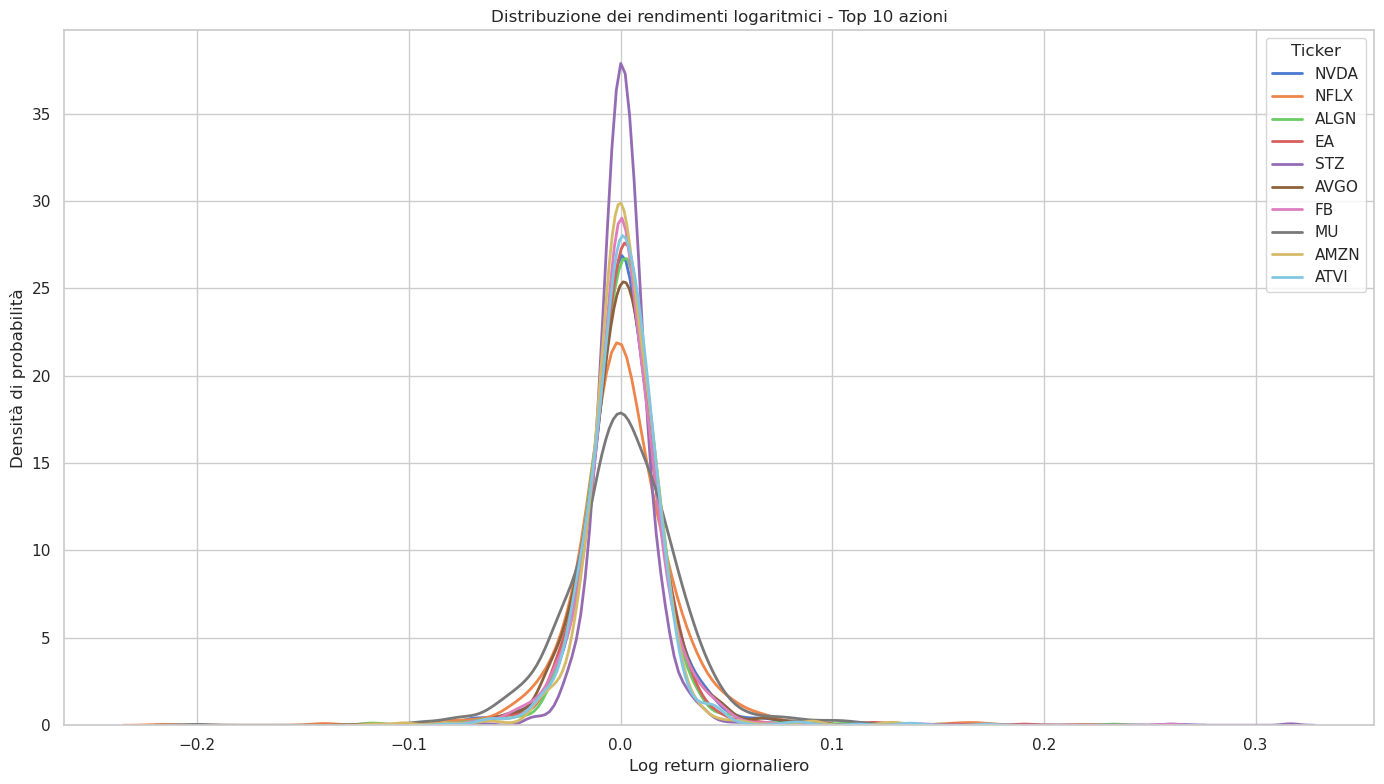

In [35]:
sns.set(style="whitegrid", palette="muted")

plt.figure(figsize=(14, 8))

#curva di densità
top_10_tickers = ['NVDA', 'NFLX', 'ALGN', 'EA', 'STZ', 'AVGO', 'FB', 'MU', 'AMZN','ATVI']
for ticker in top_10_tickers:
    subset = H[H['ticker'] == ticker]
    sns.kdeplot(subset['log_return'], label=ticker, linewidth=2)

plt.title("Distribuzione dei rendimenti logaritmici - Top 10 azioni")
plt.xlabel("Log return giornaliero")
plt.ylabel("Densità di probabilità")
plt.legend(title="Ticker")
plt.tight_layout()
plt.show()


# Rendimento Cumulato

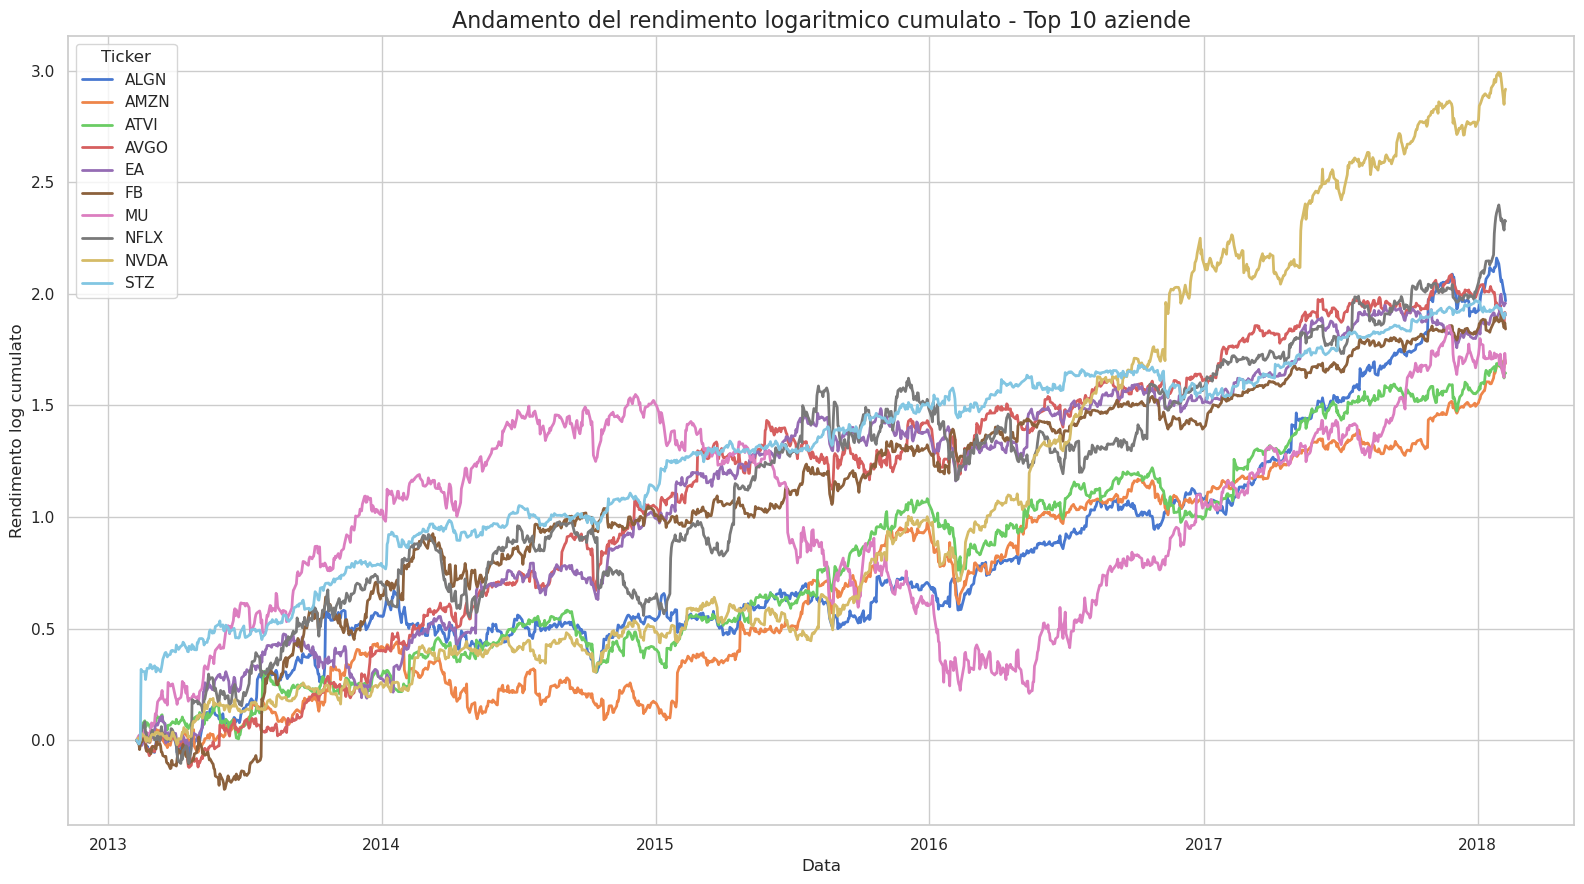

In [42]:
# Rendimento cumulato
top_10_tickers = ['NVDA', 'NFLX', 'ALGN', 'EA', 'STZ', 'AVGO', 'FB', 'MU', 'AMZN','ATVI']
df_filtered = H[H['ticker'].isin(top_10_tickers)]

plt.figure(figsize=(16, 9))
sns.lineplot(data=df_filtered, x='date', y='cumulative_log_return', hue='ticker', linewidth=2)

plt.title("Andamento del rendimento logaritmico cumulato - Top 10 aziende", fontsize=16)
plt.xlabel("Data")
plt.ylabel("Rendimento log cumulato")
plt.legend(title="Ticker")
plt.grid(True)
plt.tight_layout()
plt.show()

# Rendimento per mesi

In [44]:
# media per mese
Avg= '''
SELECT
    toYear(date) AS year,
    toMonth(date) AS month,
    avg(log_return) * 100 AS avg_monthly_log_return_pct
FROM sp500_stocks_with_returns
GROUP BY year, month
ORDER BY year, month

'''

A = query_to_df(Avg)
A

,year,month,avg_monthly_log_return_pct
0,2013,2,-0.010973
1,2013,3,0.203663
2,2013,4,0.074273
3,2013,5,0.085744
4,2013,6,-0.063078
...,...,...,...
56,2017,10,0.033020
57,2017,11,0.160226
58,2017,12,0.048736
59,2018,1,0.194036


In [45]:
A_f = A[~((A['year'].isin([2013, 2018])) & (A['month'] == 2))]


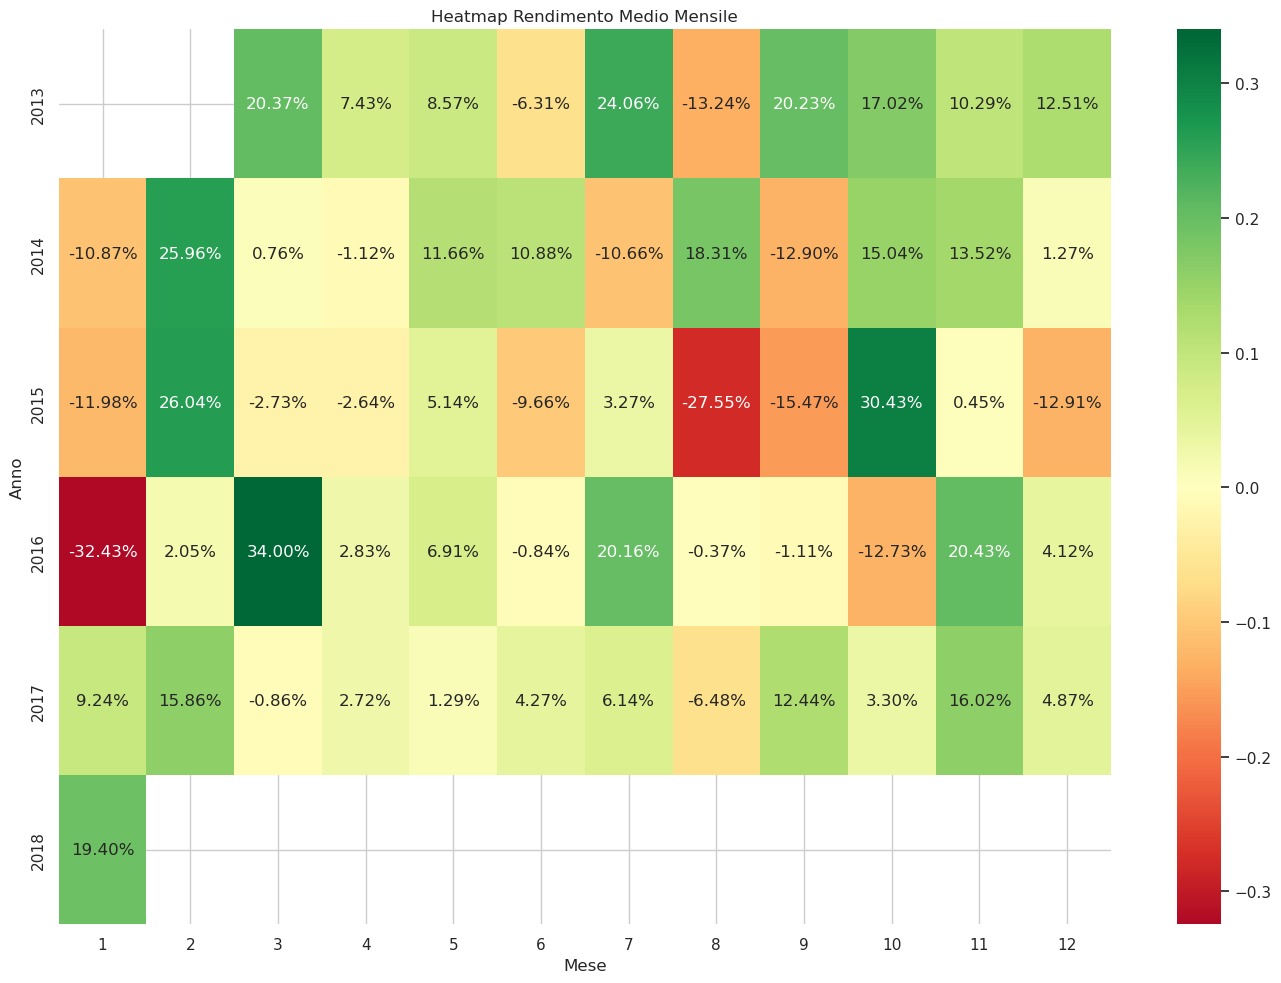

In [48]:
import seaborn as sns

pivot = A_f.pivot(index='year', columns='month', values='avg_monthly_log_return_pct')

plt.figure(figsize=(14, 10))
sns.heatmap(pivot, annot=True, fmt=".2%", cmap="RdYlGn", center=0)

plt.title("Heatmap Rendimento Medio Mensile")
plt.xlabel("Mese")
plt.ylabel("Anno")
plt.tight_layout()
plt.show()
